In [1]:
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 89.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 26.7 MB/s eta 0:00:00
 

In [2]:
# import torch

import os
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from simpletransformers.classification import ClassificationModel, ClassificationArgs
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [3]:
OLIDv1_train_df = (pd.read_csv("olid-train-small.csv")).drop("id",axis = 1)  # length 5852
hasoc_train_df = (pd.read_csv("hasoc-train.csv")).drop("id",axis = 1)       # length 5852
OLIDv1_test_df = (pd.read_csv("olid-test.csv")).drop("id",axis = 1)         # length 860

In [4]:
# Split the OLIDv1_train_df into input features and labels
X_olid = OLIDv1_train_df['text']
Y_olid = OLIDv1_train_df['labels']

# Split the hasoc_train_df into input features and labels
X_hasoc = hasoc_train_df['text']
Y_hasoc = hasoc_train_df['labels']

# Split the OLIDv1_train_df dataset into a training set and a validation set
X_train_olid, X_val_olid, Y_train_olid, Y_val_olid = train_test_split(X_olid, Y_olid, test_size=0.2, random_state=42)


train_olid = pd.concat([X_train_olid, Y_train_olid], axis=1)
val_olid = pd.concat([X_val_olid, Y_val_olid], axis=1)

# Split the hasoc_train_df dataset into a training set and a validation set
X_train_hasoc, X_val_hasoc, Y_train_hasoc, Y_val_hasoc = train_test_split(X_hasoc, Y_hasoc, test_size=0.2, random_state=42)

train_hasoc = pd.concat([X_train_hasoc, Y_train_hasoc], axis=1)
val_hasoc = pd.concat([X_val_hasoc, Y_val_hasoc], axis=1)

In [5]:
# Function to print and plot confusion matrix
def print_and_plot_confusion_matrix(true_labels, predicted_labels, experiment_name):
    cm = confusion_matrix(true_labels, predicted_labels)
    print(f'Confusion Matrix for {experiment_name}:')
    print(cm)

    # Plotting the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust the font size for better visualization
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['No hate', 'Hate'],
                yticklabels=['No hate', 'Hate'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {experiment_name}')
    plt.show()

In [6]:
# Function to calculate and print classification report
def print_classification_report(true_labels, predicted_labels, experiment_name):
    report = classification_report(true_labels, predicted_labels)
    print(f'Classification Report for {experiment_name}:')
    print(report)

In [7]:
def plot_losses(training_log,formatted_experiment_name):
    plt.plot(training_log['train_loss'], label='training Loss')
    plt.plot(training_log['eval_loss'], label='validation Loss')
    plt.title('Training and validation loss over epochs \n'+formatted_experiment_name)
    plt.xlabel('Evaluation Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# without hyperparameter optimization


In [40]:
# Function to load BERT model, fine-tune, and evaluate, then print metrics, confusion matrix, and classification report
def fine_tune_and_evaluate(experiment_name, train_dataset, val_dataset, test_dataset,
                           model_type, model_case, retrain=False):
    train_dataset_copy = train_dataset.copy()

    # Set up model directories and arguments
    model_directory = f"output/{model_type}/{model_case}/{experiment_name}"
    best_model_directory = model_directory + '/best_model'
    model_arguments = ClassificationArgs(output_dir=model_directory,
                                         best_model_dir=best_model_directory,
                                         save_best_model=True,
                                         reprocess_input_data = True,
                                         overwrite_output_dir=True,
                                         no_cache=True,

                                         evaluate_during_training = True,
                                         evaluate_during_training_verbose = True,
                                        #  evaluate_during_training_steps = 120,
                                        #  use_cached_eval_features = True,
                                        #  save_eval_checkpoints = True,
                                         save_model_every_epoch = False,

                                         use_early_stopping = True,
                                         early_stopping_metric = "eval_loss",
                                         early_stopping_metric_minimize = True,
                                         early_stopping_patience = 2,
                                         early_stopping_delta = 0.01,

                                         learning_rate= 1e-6,
                                         num_train_epochs=5,
                                        #  train_batch_size=32,
                                        #  eval_batch_size=32,
                                         max_seq_length = 128
                                         )

    # Train or load the model based on the existence of the model directory
    if not os.path.exists(model_directory) or retrain:
        model = ClassificationModel(model_type, model_case, args=model_arguments, use_cuda=True)
        model.train_model(train_dataset, eval_df = val_dataset)
    else:
        model = ClassificationModel(model_type, model_directory, args=model_arguments, use_cuda=True)

    # Make predictions on the test dataset
    test_predictions = model.predict(list(test_dataset.text))[0]

    # Format the experiment name for display
    formatted_experiment_name = f'{model_type}" / "{model_case}" / "{experiment_name}'

    # Print and plot confusion matrix
    print_and_plot_confusion_matrix(test_dataset.labels, test_predictions, formatted_experiment_name)

    # Print classification report
    print_classification_report(test_dataset.labels, test_predictions, formatted_experiment_name)

       # Load the training log
    training_log = pd.read_csv(model_directory +"/training_progress_scores.csv")

    # Plot the losses
    plot_losses(training_log,formatted_experiment_name)

In [ ]:
# Train and evaluate the model
fine_tune_and_evaluate(experiment_name='in-domain-experiment',
                       train_dataset = train_olid, val_dataset = val_olid,
                       test_dataset = OLIDv1_test_df,
                       model_type = 'bert', model_case='GroNLP/hateBERT',retrain=True)


# `with hyperparameter optimization`

In [42]:
def fine_tune_and_evaluate(experiment_name, train_dataset, val_dataset, test_dataset,
                           model_type, model_case, retrain=False,
                           learning_rate=1e-6, num_train_epochs=5, train_batch_size=32):

    train_dataset_copy = train_dataset.copy()

    # Set up model directories and arguments
    model_directory = f"output/{model_type}/{model_case}/{experiment_name}"
    best_model_directory = model_directory + '/best_model'
    model_arguments = ClassificationArgs(output_dir=model_directory,
                                         best_model_dir=best_model_directory,
                                         save_best_model=True,
                                         reprocess_input_data = True,
                                         overwrite_output_dir=True,
                                         no_cache=True,

                                         evaluate_during_training = True,
                                         evaluate_during_training_verbose = True,
                                         save_model_every_epoch = False,
                                         use_early_stopping = True,
                                         early_stopping_metric = "eval_loss",
                                         early_stopping_metric_minimize = True,
                                         early_stopping_patience = 2,
                                         early_stopping_delta = 0.01,

                                         learning_rate=learning_rate,
                                         num_train_epochs=num_train_epochs,
                                         train_batch_size=train_batch_size,
                                         max_seq_length = 128
                                         )

    # Train or load the model based on the existence of the model directory
    if not os.path.exists(model_directory) or retrain:
        model = ClassificationModel(model_type, model_case, args=model_arguments, use_cuda=True)
        model.train_model(train_dataset, eval_df=val_dataset)
    else:
        model = ClassificationModel(model_type, model_directory, args=model_arguments, use_cuda=True)

    # Make predictions on the test dataset
    test_predictions = model.predict(list(test_dataset.text))[0]

    # Format the experiment name for display
    formatted_experiment_name = f'{model_type}" / "{model_case}" / "{experiment_name}'

    # Print and plot confusion matrix
    print_and_plot_confusion_matrix(test_dataset.labels, test_predictions, formatted_experiment_name)

    # Print classification report
    print_classification_report(test_dataset.labels, test_predictions, formatted_experiment_name)

    # Load the training log
    training_log = pd.read_csv(model_directory + "/training_progress_scores.csv")

    # Plot the losses
    plot_losses(training_log, formatted_experiment_name)

In [46]:
# Manual hyperparameter tuning loop
hyperparameters = {
    'learning_rate': [1e-5, 1e-4, 1e-3],
    'num_train_epochs': [3, 5, 10],
    'train_batch_size': [16, 32, 64]
}

for learning_rate in hyperparameters['learning_rate']:
    for num_train_epochs in hyperparameters['num_train_epochs']:
        for train_batch_size in hyperparameters['train_batch_size']:
          print("="*20)
          print (f"learning_rate {learning_rate}, num_train_epochs {num_train_epochs}, train_batch_size {train_batch_size}")
          print("="*20)

          fine_tune_and_evaluate(experiment_name='hyperparameter-tuned-experiment',
                                   train_dataset=train_olid, val_dataset=val_olid,
                                   test_dataset=OLIDv1_test_df, model_type='bert',
                                   model_case='GroNLP/hateBERT', retrain=True,
                                   learning_rate=learning_rate, num_train_epochs=num_train_epochs,
                                   train_batch_size=train_batch_size)

learning_rate 1e-05, num_train_epochs 3, train_batch_size 16


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1168 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/73 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# other model (SVC)

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from scipy.sparse import hstack
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [48]:
def train_and_evaluate(X_train, Y_train, X_test, Y_test, name=None):
    # Create CountVectorizer objects
    vec_word = CountVectorizer(analyzer='word', ngram_range=(1, 1), lowercase=False)
    vec_char = CountVectorizer(analyzer='char', ngram_range=(3, 3), lowercase=False)

    # Transform the text data
    X_train = hstack((vec_word.fit_transform(X_train), vec_char.fit_transform(X_train)))
    X_test = hstack((vec_word.transform(X_test), vec_char.transform(X_test)))

    # Initialize and train the classifier
    clf_svc = LinearSVC(random_state=0)
    clf_svc.fit(X_train, Y_train)

    # Predict on the test set
    predicted = clf_svc.predict(X_test)

    # Print classification report
    print(classification_report(Y_test, predicted))

    # Calculate and plot the confusion matrix
    cm = confusion_matrix(Y_test, predicted)
    display_labels = np.unique(Y_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

    disp.plot(cmap=plt.cm.Blues)
    plt.title(name)
    plt.show()

    # Return the trained classifier
    return clf_svc


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.72      0.76      0.74       707
           1       0.60      0.55      0.57       464

    accuracy                           0.68      1171
   macro avg       0.66      0.65      0.66      1171
weighted avg       0.67      0.68      0.67      1171



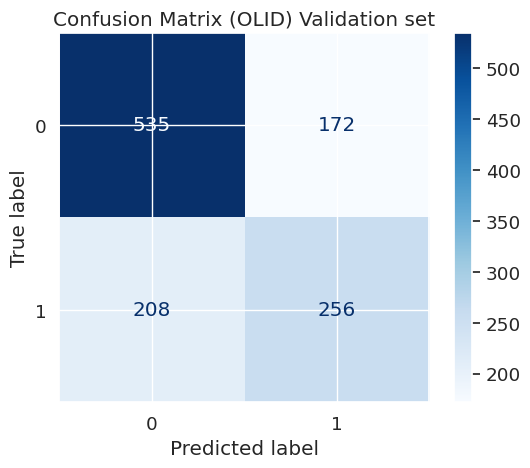

In [49]:
# Train and validate the classifier on the in-domain (OLID) dataset
classifier_olid = train_and_evaluate(X_train_olid, Y_train_olid, X_val_olid, Y_val_olid, name = "Confusion Matrix (OLID) Validation set")

In [51]:
# For Test set
def evaluate_classifier_on_test_set(classifier, X_train_olid, olid_test,name_cm=None):
    # Create CountVectorizer objects
    vec_word = CountVectorizer(analyzer='word', ngram_range=(1, 1), lowercase=False)
    vec_char = CountVectorizer(analyzer='char', ngram_range=(3, 3), lowercase=False)

    # Fit and transform the training data
    X_train_word = vec_word.fit_transform(X_train_olid)
    X_train_char = vec_char.fit_transform(X_train_olid)
    X_train_olid = hstack((X_train_word, X_train_char))

    # Transform the test data using the same vectorizers
    X_test_word = vec_word.transform(olid_test['text'])
    X_test_char = vec_char.transform(olid_test['text'])
    X_test_olid = hstack((X_test_word, X_test_char))

    # Use the trained classifier to make predictions on the test data
    predicted_test = classifier.predict(X_test_olid)

    # Print classification report for the test set
    print(classification_report(olid_test['labels'], predicted_test))

    # Calculate and plot the confusion matrix for the test set
    cm_test = confusion_matrix(olid_test['labels'], predicted_test)
    display_labels_test = np.unique(olid_test['labels'])
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels_test)
    disp_test.plot(cmap=plt.cm.Blues)
    plt.title(name_cm)
    plt.show()

              precision    recall  f1-score   support

           0       0.81      0.73      0.76       620
           1       0.44      0.55      0.49       240

    accuracy                           0.68       860
   macro avg       0.62      0.64      0.63       860
weighted avg       0.70      0.68      0.69       860



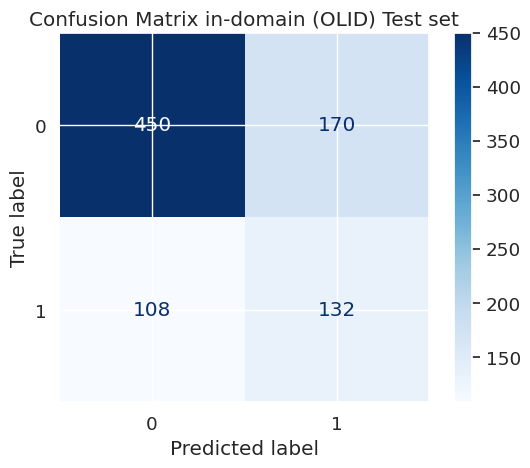

In [53]:
# Evaluate the classifier on the in-domain (OLID-test) dataset
evaluate_classifier_on_test_set(classifier_olid, X_train_olid, OLIDv1_test_df, name_cm="Confusion Matrix in-domain (OLID) Test set")

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.70      0.69      0.69       734
           1       0.49      0.50      0.49       437

    accuracy                           0.62      1171
   macro avg       0.59      0.59      0.59      1171
weighted avg       0.62      0.62      0.62      1171



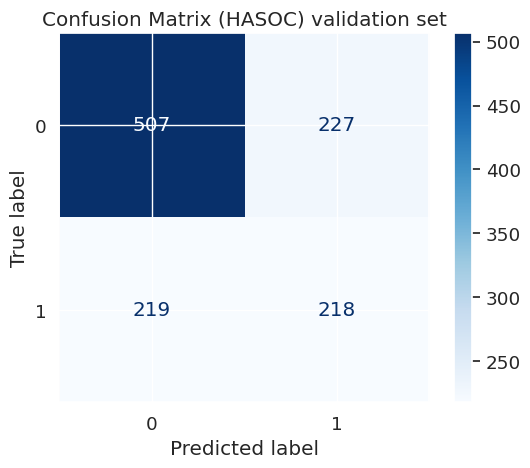

In [54]:
# Train and validate the classifier on the HASOC dataset
classifier_hasoc = train_and_evaluate(X_train_hasoc, Y_train_hasoc, X_val_hasoc, Y_val_hasoc, name= "Confusion Matrix (HASOC) validation set")

              precision    recall  f1-score   support

           0       0.76      0.69      0.72       620
           1       0.35      0.43      0.39       240

    accuracy                           0.62       860
   macro avg       0.55      0.56      0.56       860
weighted avg       0.64      0.62      0.63       860



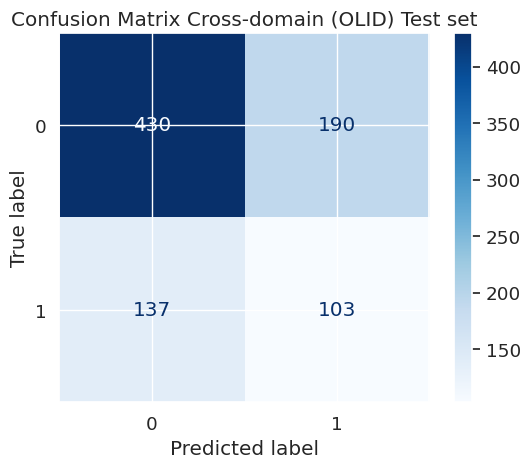

In [56]:
# Evaluate the classifier on the coss-domain (OLID-test) dataset
evaluate_classifier_on_test_set(classifier_hasoc, X_train_hasoc, OLIDv1_test_df, name_cm="Confusion Matrix Cross-domain (OLID) Test set")